# Connect to Drive
Connect to the folder containing files  
- checkpoint_step001000000_ema.pth
- autovc.ckpt 
- 3000000-BL.ckpt


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls

gdrive	sample_data


In [ ]:
%cd gdrive/My Drive/Insubria/Magistrale/Tesi/project_folder/NicolaProject/autovc

/content/gdrive/My Drive/Insubria/Magistrale/Tesi/project_folder/NicolaProject/autovc


#Install and Import

In [ ]:
%%bash
pip install univoc pyloudnorm
pip install wavenet_vocoder
pip install wavio
pip install spleeter
apt install ffmpeg

  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=f08b31847ac341ffe72955f801ba4ab6988a5d9a547acde023eff89735ff52d7
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
Successfully built antlr4-python3-runtime
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Created wheel for wavenet-vocoder: filename=wavenet_vocoder-0.1.1-py3-none-any.whl size=12678 sha256=7bb1532f416ef536d57a08e74dd8d063c07089f50ec980bac23903538b0dd625
  Stored in directory: /root/.cache/pip/wheels/45/b9/b3/5961fda4d2ba5bc9a8d416844b30d590f597674a690162766f
Successfully built wavenet-vocoder
  Created wheel for librosa: filename=librosa-0.8.0-py3-none-any.whl size=201395 sha256=821bf47b9b17d208b068048c5252f9893cfcaf824a112e6879fcf22a4216d143
  Stored in directory: /root/.cache/pip/wheels/de/1e/aa/d9

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import pickle
from math import ceil
from tqdm import tqdm
import librosa
from wavenet_vocoder import builder
import soundfile as sf
from scipy import signal
from scipy.signal import get_window
from librosa.filters import mel
from numpy.random import RandomState
from collections import OrderedDict
import time
import datetime
from torch.utils import data
from multiprocessing import Process, Manager 
from IPython.display import Audio
from model_bl import D_VECTOR
from model_vc import Generator
from synthesis import build_model
from synthesis import wavegen
import wavio as wv
import pyloudnorm as pyln
import matplotlib.pyplot as plt
from univoc import Vocoder

# Audio files

In [ ]:
path1= "wavs/p228/p228_011.wav"
path2= "wavs/p226/p226_021.wav"

#path1= "v1_Pak_70/id0059/English/fLmv5exbzmg/00108.wav"
#path2= "v1_Pak_70/id0030/English/OMBLbkLFeGY/00049.wav"

#path1= "wavs/i300/galatea_01_barrili_f000006.wav"
#path2= "wavs/i301/imalavoglia_00_verga_f000010.wav"

In [ ]:
Audio(path1)

In [ ]:
Audio(path2)

# Remove noise from audio files

In [ ]:
#%cd "/content"

In [ ]:
"""prefix_path = "gdrive/My\ Drive/Insubria/Magistrale/Tesi/project_folder/NicolaProject/autovc/"
path1_completed = prefix_path + path1
path2_completed = prefix_path + path2
destination_folder = "/content"
print(path1_completed)
%cp $path1_completed $destination_folder
%cp $path2_completed $destination_folder"""

'prefix_path = "gdrive/My\\ Drive/Insubria/Magistrale/Tesi/project_folder/NicolaProject/autovc/"\npath1_completed = prefix_path + path1\npath2_completed = prefix_path + path2\ndestination_folder = "/content"\nprint(path1_completed)\n%cp $path1_completed $destination_folder\n%cp $path2_completed $destination_folder'

In [ ]:
"""os.environ['IN1'] = path1[-9:]
os.environ['IN2'] = path2[-9:]
os.environ['SPL'] = 'spleeter:2stems'
os.environ['OUT'] = 'output'

print('Input1:')
Audio(path1[-9:])"""

"os.environ['IN1'] = path1[-9:]\nos.environ['IN2'] = path2[-9:]\nos.environ['SPL'] = 'spleeter:2stems'\nos.environ['OUT'] = 'output'\n\nprint('Input1:')\nAudio(path1[-9:])"

In [ ]:
#print('Input2:')
#Audio(path2[-9:])

In [ ]:
#!mkdir -p $OUT
#!spleeter separate -p $SPL -o $OUT $IN1
#!spleeter separate -p $SPL -o $OUT $IN2

In [ ]:
#Audio('output/' + path1[-9:-4] + '/vocals.wav')

In [ ]:
#Audio('output/' + path1[-9:-4] + '/accompaniment.wav')

# Mel speacker encoder

In [ ]:
#equivalente di !python make_spect.py

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a
    
    
def pySTFT(x, fft_length=1024, hop_length=256):
    
    x = np.pad(x, int(fft_length//2), mode='reflect')
    
    noverlap = fft_length - hop_length
    shape = x.shape[:-1]+((x.shape[-1]-noverlap)//hop_length, fft_length)
    strides = x.strides[:-1]+(hop_length*x.strides[-1], x.strides[-1])
    result = np.lib.stride_tricks.as_strided(x, shape=shape,
                                             strides=strides)
    
    fft_window = get_window('hann', fft_length, fftbins=True)
    result = np.fft.rfft(fft_window * result, n=fft_length).T
    
    return np.abs(result)    
    
    
mel_basis = mel(16000, 1024, fmin=90, fmax=7600, n_mels=80).T
min_level = np.exp(-100 / 20 * np.log(10))
b, a = butter_highpass(30, 16000, order=5)

def prepare_spectrogram(audio, speaker_number):
    prng = RandomState(int(speaker_number))
    # Read audio file
    x, fs = sf.read(audio)
    # Remove drifting noise
    y = signal.filtfilt(b, a, np.ravel(x)) #HAI AGGIUNTO np.ravel(), il risultato sembrerebbe non cambiare
    # Ddd a little random noise for model roubstness
    wav = y * 0.96 + (prng.rand(y.shape[0])-0.5)*1e-06
    # Compute spect
    D = pySTFT(wav).T
    # Convert to mel and normalize
    D_mel = np.dot(D, mel_basis)
    D_db = 20 * np.log10(np.maximum(min_level, D_mel)) - 16
    S = np.clip((D_db + 100) / 100, 0, 1) 
    S = S.astype(np.float32)   
    return S 
        

# Speaker Encoder  
Use model_bl to encode the spectrograms.  
Generate speaker embeddings and metadata for training.  
Equivalente di !python make_metadata.py  

In [ ]:
C = D_VECTOR(dim_input=80, dim_cell=768, dim_emb=256).eval().cuda()
c_checkpoint = torch.load('3000000-BL.ckpt')
new_state_dict = OrderedDict()
for key, val in c_checkpoint['model_b'].items():
    new_key = key[7:]
    new_state_dict[new_key] = val
C.load_state_dict(new_state_dict)
num_uttrs = 10
len_crop = 128

def process_speacker(tmp): 
    left = np.random.randint(0, tmp.shape[0]-len_crop)
    melsp = torch.from_numpy(tmp[np.newaxis, left:left+len_crop, :]).cuda()
    emb = C(melsp)
    return emb.detach().squeeze().cpu().numpy()

# Melc vocoder

In [ ]:
def melspectrogram(
    wav,
    sr=16000,
    hop_length=200,
    win_length=800,
    n_fft=2048,
    n_mels=128,
    fmin=50,
    preemph=0.97,
    top_db=80,
    ref_db=20,
):
    mel = librosa.feature.melspectrogram(
        librosa.effects.preemphasis(wav, coef=preemph),
        sr=sr,
        hop_length=hop_length,
        win_length=win_length,
        n_fft=n_fft,
        n_mels=n_mels,
        fmin=fmin,
        norm=1,
        power=1,
    )
    logmel = librosa.amplitude_to_db(mel, top_db=None) - ref_db
    logmel = np.maximum(logmel, -top_db)
    return logmel / top_db

In [ ]:
meter = pyln.Meter(16000)

def wav2melV2(wav):
    loudness = meter.integrated_loudness(wav)
    wav = pyln.normalize.loudness(wav, loudness, -24)
    peak = np.abs(wav).max()
    if peak >= 1:
        wav = wav / peak * 0.999
    mel = melspectrogram(wav, n_mels=80)
    mel = np.transpose(mel, (1, 0))
    return mel

# AutoVC

In [ ]:
def pad_seq(x, base=32):
    len_out = int(base * ceil(float(x.shape[0])/base))
    len_pad = len_out - x.shape[0]
    assert len_pad >= 0
    return np.pad(x, ((0,len_pad),(0,0)), 'constant'), len_pad

device = 'cuda:0'
G = Generator(32,256,512,32).eval().to(device)

model_path = 'esperimenti/lambda1/batch_size24/'
model_trained = 'generator_Pak31000'
model_extension = '.pth'
g_checkpoint = torch.load(model_path + model_trained + model_extension,map_location='cuda:0') #autovc.ckpt
G.load_state_dict(g_checkpoint) #g_checkpoint['model']

def prepare_input(s1, emb1, emb2, G):
    x_org, len_pad = pad_seq(s1)
    uttr_org = torch.from_numpy(x_org[np.newaxis, :, :]).to(device)
    emb_org = torch.from_numpy(emb1[np.newaxis, :]).to(device)
    
    emb_trg = torch.from_numpy(emb2[np.newaxis, :]).to(device)
    
    with torch.no_grad():
            _, x_identic_psnt, _ = G(uttr_org, emb_org, emb_trg)
    if len_pad == 0:
        uttr_trg = x_identic_psnt[0, 0, :, :]
    else:
        uttr_trg = x_identic_psnt[0, 0, :-len_pad, :]
    return uttr_trg

# PreProcessing

In [ ]:
wav1, _ = librosa.load(path1, sr=16000)
vocoder_mel1 = wav2melV2(wav1)
speacker_encoder_mel1 = prepare_spectrogram(path1, speaker_number=0)

wav2, _ = librosa.load(path2, sr=16000)
vocoder_mel2 = wav2melV2(wav2)
speacker_encoder_mel2 = prepare_spectrogram(path2, speaker_number=1)

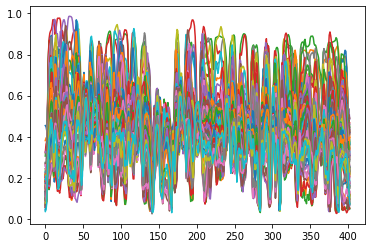

In [ ]:
plt.plot(speacker_encoder_mel1)
plt.show()

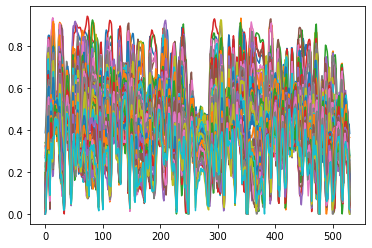

In [ ]:
plt.plot(speacker_encoder_mel2)
plt.show()

# Encod

In [ ]:
emb1 = process_speacker(speacker_encoder_mel1)
emb2 = process_speacker(speacker_encoder_mel2)

# AutoVC

In [ ]:
G = Generator(32,256,512,32).eval().to(device)
g_checkpoint = torch.load(model_path + model_trained + model_extension,map_location='cuda:0') #autovc.ckpt
G.load_state_dict(g_checkpoint) #g_checkpoint['model']

spect_vc1 = prepare_input(vocoder_mel1, emb1, emb2, G)
print(spect_vc1.shape)

torch.Size([516, 80])


# Vocoder

In [ ]:
vocoder = Vocoder.from_pretrained(
    "https://github.com/bshall/UniversalVocoding/releases/download/v0.2/univoc-ljspeech-7mtpaq.pt",
).cuda()

torch_mel = spect_vc1.unsqueeze(dim=0)
torch_mel = torch_mel.cuda()
with torch.no_grad():
    wav2, sr = vocoder.generate(torch_mel)

name = path1 + '_' + path2
name = name.replace('/', '_')
name = name.replace('.wav', '')
file_output = model_trained + '.wav'
print(file_output)
sf.write(file_output, wav2, sr)

Downloading: "https://github.com/bshall/UniversalVocoding/releases/download/v0.2/univoc-ljspeech-7mtpaq.pt" to /root/.cache/torch/hub/checkpoints/univoc-ljspeech-7mtpaq.pt


  0%|          | 0.00/24.7M [00:00<?, ?B/s]

generator_Pak31000.wav


In [ ]:
Audio(file_output)

In [ ]:
!ls

 3000000-BL.ckpt		    original_dataset_spmel
 autovc				    original_dataset_spmel_new
 autovc.ckpt			    output
 checkpoints			    output_folder
 checkpoint_step001000000_ema.pth   pak_pth
'Copia di AutoVCallinone.ipynb'     pak_results
'Copia di SpleeterForAll.ipynb'     pretrained_models
'Copia di TrainAutoVC.ipynb'	    __pycache__
'Copy of UseVocoder.ipynb'	    README.md
 data_loader.py			    README_OLD.md
 esperimenti			    results.pkl
 generator_Pak31000.wav		    solver_encoder.py
 generator_Pak33000_new.wav	    SpleeterForRemoveNoise.ipynb
 generator_Pak33000.wav		    spmel
 generator_wav48.pt		    synthesis.py
 generator_wav48.pt.tmp		    test_new_vocoder.ipynb
 hparams.py			    test_vocoder
 italian_audio			    TestVocoder.ipynb
 LICENSE			    train_newmodel.py
 lrschedule.py			    train_univoc.ipynb
 main.py			    train_vocoder.ipynb
 make_metadata.py		    univoc-ljspeech-7mtpaq.pt
 make_spect_folder.py		    v1_Pak_70
 make_spect_for_shah.py		    v1_Pak_71
 make_spect_for_vox

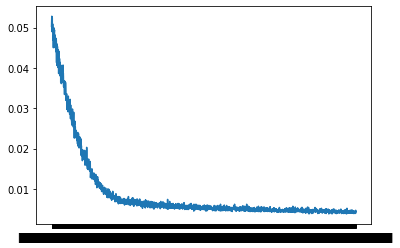

In [ ]:
import csv
import pandas as pd
import matplotlib.pyplot as plt

losses = []                       # The list where we will store results.
linenum = 0
substr = "G/loss_id:".lower()          # Substring to search for.
with open (model_path + 'log_lambda1_batch24.log', 'rt') as myfile:
    for line in myfile:
        linenum += 1
        if line.lower().find(substr) != -1:    # if case-insensitive match,
            losses.append(line.rstrip('\n'))
            
    stripped = (line.strip(',') for line in losses)
    lines = (line.split() for line in stripped if line)
    
df = pd.DataFrame(lines)
df.drop(df.columns[[0, 2, 4, 6, 8]], axis=1, inplace=True)
df.columns = ["Elapsed", "Iteration", "G/loss_id", "G/loss_id_psnt", "G/loss_cd"]
df.replace(',','', regex=True, inplace=True)
df["G/loss_id"] = pd.to_numeric(df["G/loss_id"])
df["G/loss_id_psnt"] = pd.to_numeric(df["G/loss_id_psnt"])
df["G/loss_cd"] = pd.to_numeric(df["G/loss_cd"])
#print(df)

plt.plot(df['Iteration'],df['G/loss_id'])
plt.show()

In [ ]:
"""from google.colab import files
files.download(file_output)"""

'from google.colab import files\nfiles.download(file_output)'

In [ ]:
"""save_path = './pak_results/60speaker'

completeName = os.path.join(save_path, file_output)
print(completeName)

wv.write(completeName, waveform, 16000, sampwidth=2)"""

"save_path = './pak_results/60speaker'\n\ncompleteName = os.path.join(save_path, file_output)\nprint(completeName)\n\nwv.write(completeName, waveform, 16000, sampwidth=2)"